# Structural helath monitoring

In this notebook we are going to be starting to think about how we might use the Hawk data to inform a structural health monitoring scheme. Our main aim is to explore features of the data that are going to be sensitive to the presence of damage in the structure. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from hawk import SBW

sns.set_theme("notebook")
sns.set_style("ticks")
sns.set_palette("Set2")

As a first step, lets take only the natural frequency values from the data and explore them with a straightforward RFP approach using the ranges that we defined previously.

In [3]:
# Recalling our RFP implementation from last episode...

# Hermitian transpose
def HT(a):
    return a.conj().T

# Rational fraction polynomial model
def RFP(H, w, n_modes, oob_terms=0):
    # Specify the orders of our approximation
    m = (
        n_modes * 2 + 1 + oob_terms
    )  # number of coefficients in the numerator polynomial
    n = (
        n_modes * 2 + 1
    )  # number of coefficients in the denominator -1 because we fix b_n=1

    # complex frequency vector
    iw = 1j * w

    # Build monomial basis matricies
    Phi_a = iw[:, None] ** np.arange(m)
    Phi_b_all = iw[:, None] ** np.arange(n)
    Phi_b = Phi_b_all[:, :-1]  # ignore last column because bn=1

    # preallocate some calculations for speed
    Phi_bH = Phi_b * H[:, None]
    Hiwn = H * Phi_b_all[:, -1]
    D = -HT(Phi_a) @ (Phi_bH)

    # form the block matricies
    M = np.block([[HT(Phi_a) @ Phi_a, D], [D.T, HT(Phi_bH) @ (Phi_bH)]])
    x = np.block([HT(Phi_a) @ Hiwn, -HT(Phi_bH) @ Hiwn])

    # Solve and extract the coefficients of the polynomials
    AB = np.linalg.solve(np.real(M), np.real(x))
    a = AB[:m, None]
    b = np.append(AB[m:], 1)[:, None]

    # Generate the predicted FRF
    H_pred = (Phi_a @ a) / (Phi_b_all @ b)

    # Pull out the modal porperties
    roots_b = sorted(np.roots(np.flip(b[:, 0])))[
        ::-2
    ]  # remove every other becaus they are conj pairs
    wns = np.abs(roots_b)
    zetas = -np.real(roots_b) / wns
    return H_pred, wns, zetas

def get_wns(ranges, ws, frf, oob=6):
    wns = []
    for (low, high), n in ranges:
        idx = np.logical_and(ws > low, ws < high)
        _, wn, _ = RFP(frf[idx], ws[idx], n, oob_terms=oob)
        wns.extend(wn)
    return np.array(wns)

In [20]:
# Extracting the nartural frequencies

### You should experiment with these:
data_dir = './hawk_data'  # use your cached data if you have it downloaded from previous notebooks

damage_locs = ['DS_TLE'] # tip leading edge
ranges = (
    ((5, 9), 1),
    ((12, 14), 1),
    ((15, 19), 1),
    ((22, 24), 2),
    ((26, 30), 1),
    ((30.5, 31), 1),
    ((35, 37), 1),
    ((40.5, 44), 2),
    ((48.5, 54), 2),
    ((86, 90), 1),
    ((92, 100), 1),
    ((112, 118.5), 1),
    ((119.5, 122), 1),
    ((122, 125), 1),
    ((135, 138), 1),
    ((154, 162), 1),
)
###

data = SBW(data_dir)
ws = data['/LMS/xData/freq']
damage_data = [data[f'/LMS/{loc}'] for loc in damage_locs]
baseline_data = data['/LMS/BR_AR']

all_wns = []
all_damage_weights = []
all_excitation_levels = []
all_damage_locs = []

for series in [baseline_data, damage_data]:
    for kr, rep in series.items():
        if int(kr) > 1: continue
        for ks, sensor in rep.items():
            if ks[:3] in {"TRI", "EXH", "FRC"}:
                continue
            meta = sensor.describe()
            print(meta)

            frfs = sensor['frf']
            wns = get_wns(ranges, frfs[:].mean(1), ws[:], frfs[:].mean(1))

            all_wns.append(wns)
            all_damage_weights.append(float(meta['addedMass']))


{'testCampaign': 'LMS', 'testSeries': 'BR_AR', 'testRepeat': '01', 'sensorID': 'LLC-01', 'X': 0, 'Y': 1045, 'Z': -90, 'assettNumber': 151, 'gain': 10.36, 'gainDate': '', 'gainUnits': 'mV/g', 'locationUnits': 'mm', 'manufacturer': 'PCB Piezotronics', 'model': 'M353B18', 'acquisitionSampleRate': 'N/a', 'addedMass': '0', 'ampLevelPercent': '50', 'burstTimePercent': '90', 'controlIteration': 'N/a', 'controlLoop': 'Open', 'date': '14/01/2022 10:32:33', 'excitationType': 'Burst Random', 'notes': '', 'operator': 'MHA', 'randomSeed': 'N/a', 'recordingBandwith': '256', 'repetitions': 10, 'spectralLines': '8192'}


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

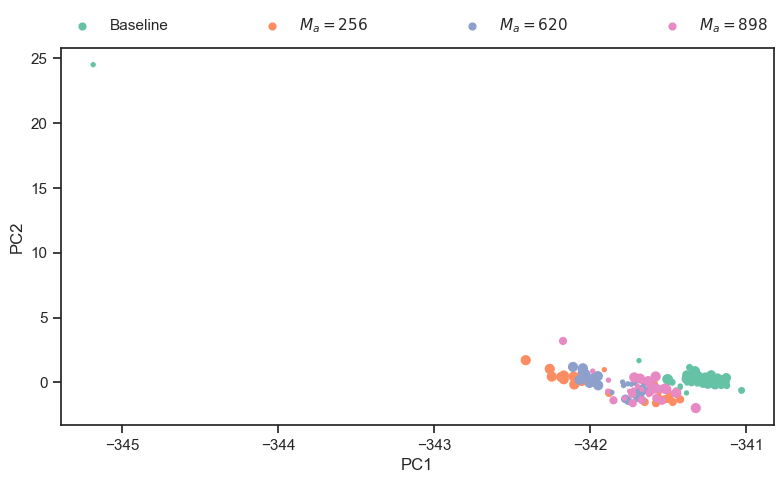

In [ ]:
# Take PCA of the natural frequencies

U, s, V = np.linalg.svd(wns, full_matrices=0)
PCS = U @ np.diag(s)

# Plotting the first 2 principal components
ll = ["Baseline", "$M_a=256$", "$M_a=620$", "$M_a=898$"]
plt.figure(figsize=(8, 5))
for d in [0, 1, 2, 3]:
    ix = [l["dmg"] == d for l in labs]
    ss = [20 * v["amp"] for i, v in zip(ix, labs) if i]
    plt.scatter(PCS[ix, 0], PCS[ix, 1], color=f"C{d}", label=ll[d], s=ss)
plt.legend(
    bbox_to_anchor=(0, 1.1, 1, 0),
    loc="upper left",
    ncols=4,
    mode="expand",
    borderaxespad=0,
    frameon=False,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

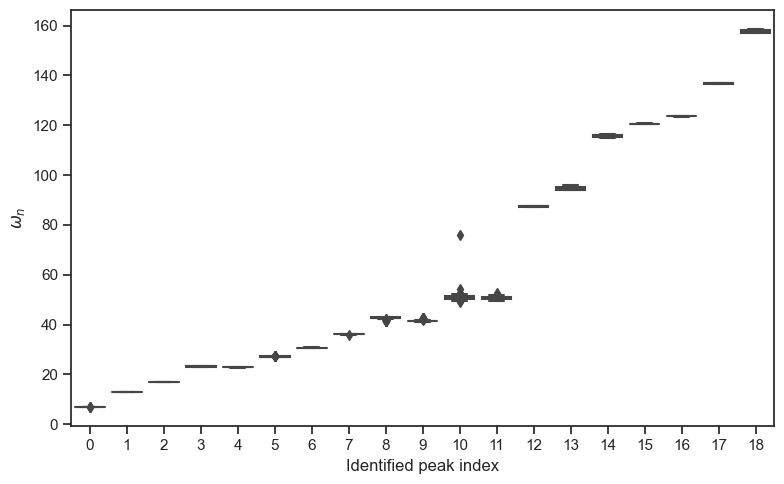

In [ ]:
# Exploring the outliers in the data

plt.figure(figsize=(8, 5))
sns.boxplot(wns)
plt.xlabel("Identified peak index")
plt.ylabel(r"$\omega_n$")
plt.tight_layout()

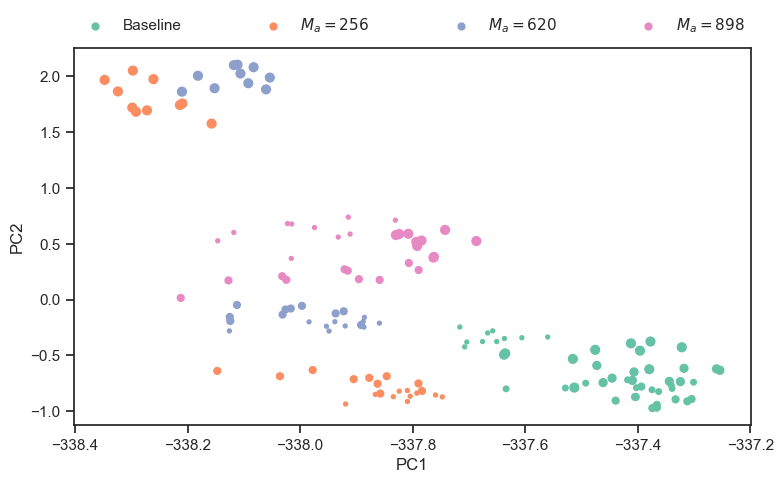

In [ ]:
# PCA again without the poorly fitted 11th mode

# remove the 10th mode from the PCA
wns_crop = np.delete(wns, [10], axis=1)

# PCA on the reduced dataset
U, s, V = np.linalg.svd(wns_crop, full_matrices=0)
PCS = U @ np.diag(s)

# Plotting the first 2 principal components
ll = ["Baseline", "$M_a=256$", "$M_a=620$", "$M_a=898$"]
plt.figure(figsize=(8, 5))
for d in [0, 1, 2, 3]:
    ix = [l["dmg"] == d for l in labs]
    ss = [20 * v["amp"] for i, v in zip(ix, labs) if i]
    plt.scatter(PCS[ix, 0], PCS[ix, 1], color=f"C{d}", label=ll[d], s=ss)
plt.legend(
    bbox_to_anchor=(0, 1.1, 1, 0),
    loc="upper left",
    ncols=4,
    mode="expand",
    borderaxespad=0,
    frameon=False,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()



Overall, we have seen that the natural frequencies do appear to be sensitive to damage. However, if we do not remove the outliers then the variance in the data can become dominated by the quality of our firring algorithm, which is not what we want!

In the next section we will look at using the specral lines themselves as features in a damage detection algorithm.


### Damage detection

Often the initial task when developing a structural health monitoring strategy is to be able to assess whether damage is present in the structure or not. Generally, this task is referred to as damage detection. 

In this notebook, we're going to look at how we can approach the task of damage detection through outlier analysis. If we believe that the data we acquire from our structure will change in some way as damage develops, then we can begin by using data that has been collected from our structure in a known undamaged state to form a baseline. As we continue to monitor our structure online where we lack prior knowledge of the damage state (e.g. damage label is now a latent state), then we can evaluate how similair our new data are to the baseline as an indication of whether we believe damage is present or not.

To assess this similairty (or to be more exact, dissimilarity), we can use a measure of novelty. If outliers begin to appear, then this can inform us about potential damage.

To begin, let's load in data from both an undamaged and damaged test series. The data representing our undamaged state is from the test series "BR_AR", whilst the data representing the damage state is taken from the test series "DS_TLE". As you may have already seen, damage is simulated through the addition of added mass at various locations on the wing. 

Before we can think about whether our structure is damaged or not, we need to think about damage sensitive features - simply put, what type of data can we collect that is going to tell us about damage growth in the structure. In SHM, we often have access to lots of physically meaningful features, such as natural frequencies, which you'll have seen in earlier notebooks. 

In this notebook, we're going to look at frequency response functions of the structure as our damage sensitive feature. 

Note - when running the code block below yourself, you'll need to set directory for downloaded data.

In [ ]:
all_data = [("BR_AR", np.arange(1,6)), ("DS_TLE", np.arange(1,10))] # the two test series we're going to load, BR_AR and DS_DLE.

opts = {
    'data':'Frequency Response Function',
    'meta':True,
    'attrs':False,
    'compress_x_axis':True,
} # some options for get_hawk_data function in hawk_tools

out = {} # empty dictionary to store data
# loop through series
for series, runs in all_data:
    # loop through runs
    for run in runs:
        run_data = get_hawk_data('LMS', series, run, download_dir = data_dir, load_kwargs=opts, ask=0, quiet=1)
        # loop through reps
        for rep, rep_data in run_data.items():
            # loop through sensors
            for sensor, sensor_data in rep_data.items():
                if sensor != 'ULC-03': continue # 1 sensor only
                if sensor[:3] in {"TRI", "EXH", "FRC", "Met"}:
                    continue
                if int(sensor[-1])<3:
                    continue
                frf = sensor_data["Frequency Response Function"]["Y_data"]["value"]
                amp = run_data[rep]['Meta']['excitation']['LMSOutput']['value']
                if 'DS' in rep:
                    dmg = run_data[rep]['Meta']['additionalMass']['weight']['value']
                    out[rep] = [frf,amp,dmg] # record FRF, test amplitude, and damage level via added mass.
                else:
                    out[rep] = [frf,amp] # if no damage, just record FRF and test amplitude

freqs = run_data[rep]['X_data']['Frequency Response Function']['value']

We get two useful outputs from this code block:
<br />
<br />
- out: dictionary relating test ID to its frequency response values, input signal amplitude of the test, and damage level (in the case of damage state data)
<br />
- freqs: frequencies corresponding to the FRF

Let's look at the FRF for one of the undamaged tests, and one of the damaged

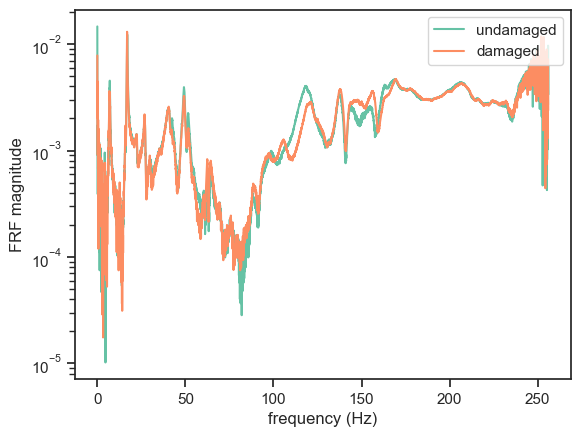

In [ ]:
plt.figure()
plt.plot(freqs,np.abs(out['BR_AR_5_1'][0]),label = 'undamaged')
plt.plot(freqs,np.abs(out['DS_TLE_9_1'][0]), label = 'damaged')
plt.yscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('FRF magnitude')
plt.legend(loc = 'upper right')

Notice the shift in both peak frequencies and amplitudes in the damage case relative to the undamaged. This tells us we have a suitable damage sensitive feature. 

Now, although we've now seen that the FRF is sensitive to damage, using the entire FRF would mean an 8192 dimensional feature vector. We can be a bit more clever, and focus on just one peak (e.g. a natural frequency) of the FRF plot that is sensitive to damage. For instance, if we zoom into ~ 156Hz


Text(0, 0.5, 'FRF magnitude')

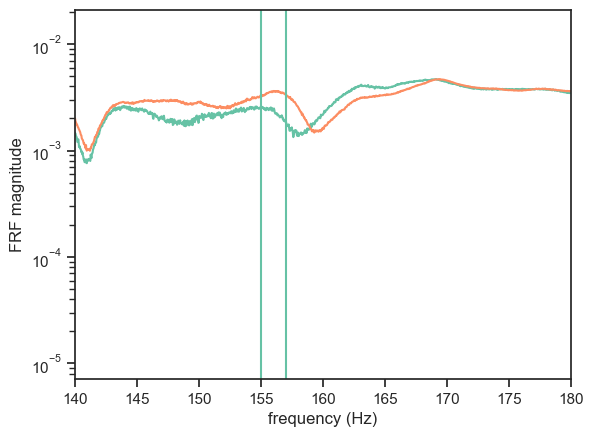

In [ ]:
plt.plot(freqs,np.abs(out['BR_AR_5_1'][0]))
plt.plot(freqs,np.abs(out['DS_TLE_9_1'][0]))
plt.yscale('log')
plt.axvline(x=155)
plt.axvline(x=157)
plt.xlim([140,180])
plt.xlabel('frequency (Hz)')
plt.ylabel('FRF magnitude')

In just this narrow region, we can still see a shift in the behaviour of the FRF. 

Taking 8 spectral lines (e.g 8 discrete freqeuncy values) as our feature vector, we can now begin our outlier analysis.

In [ ]:
# set the spectral lines that we will use in our feature vector
start_idx = int(np.where(freqs==155)[0])
end_idx = int(np.where(freqs==157)[0])
interval = 8

# preallocate useful data 

spectral_bands_undamaged = []
test_amplitude_undamaged = []
spectral_bands_damaged = []
test_amplitude_damaged = []
test_damage_severity = []

for k, v in out.items():
    if 'DS' in k:
        spectral_bands_damaged.append(v[0][start_idx:end_idx:interval])
        test_amplitude_damaged.append(v[1]) 
        test_damage_severity.append(v[2])
    else:
        spectral_bands_undamaged.append(v[0][start_idx:end_idx:interval])
        test_amplitude_undamaged.append(v[1]) 

# store spectral lines for both test series   

spectral_bands_undamaged = np.abs(spectral_bands_undamaged)  
spectral_bands_damaged = np.abs(spectral_bands_damaged)  

# input signal amplitude for each test

test_amplitude_undamaged = np.array(test_amplitude_undamaged)
test_amplitude_damaged = np.array(test_amplitude_damaged)

# mass information for damage simulation test series 

test_damage_severity = np.array(test_damage_severity)

In [ ]:
# useful tools for outlier analysis


def outlier_threshold(CI,n,p):

    # monte carlo sampling to determine threshold for outlier with confidence CI 

    # N = number of generations - fixed at 1000 
    # CI = confidence interval - e.g 95,99 

    N = 1000

    max_D = np.zeros((N,))

    for i in range(0,N):
        X = np.array(np.random.randn(n,p))
        Xcov = np.cov(X.T)
        Xcov_inv = np.linalg.inv(Xcov)
        Xmean = np.mean(X,0)

        D = np.zeros((n,))
        
        for j in range(0,n):
            D[j] = mahalanobis(X[j,:],Xmean,Xcov_inv)

        max_D[i] = np.max(D)

    D_sort = np.sort(max_D)
    idx = int(CI/(100/N))
    threshold = D_sort[idx] 
    return threshold

def plot_outlier_analysis(threshold,reference,undamaged,damaged,damage_severity):

    # Plotting function for outlier analysis. 

    # threshold = threshold for novelty
    # reference = data used to form reference statistics
    # undamaged = data from undamaged state not used in reference
    # damaged = data from damage state not used in reference
    # damage_severity = mass value used to simulate damage 

    # order data point number to appear in plot 

    x_reference = np.arange(0,len(reference.T))
    x_undamaged = np.arange(
        len(reference.T),len(reference.T)+len(undamaged.T)
        )
    x_damage = np.arange(
        len(reference.T)+len(undamaged.T), 
        len(reference.T)+len(undamaged.T) + len(damaged.T)
        )

    # group novelty arrays
    
    reference_novelty = np.vstack((
        reference,np.zeros_like(reference)
        ))
    undamaged_novelty = np.vstack((
        undamaged,np.ones_like(undamaged)
        ))
    damaged_novelty = np.vstack((
        damaged,2*np.ones_like(damaged)
        ))
    
    # collect damage levels

    dmg_lvl_1 = np.unique(damage_severity)[0]
    dmg_lvl_2 = np.unique(damage_severity)[1]
    dmg_lvl_3 = np.unique(damage_severity)[2]

    default_size = 20 # marker size 

    plt.figure()
    plt.scatter(x_reference,reference_novelty[0,:],s = default_size,marker = 'o',c = 'indigo',alpha=0.5,label='undamaged')
    plt.scatter(x_undamaged,undamaged_novelty[0,:],s = default_size,marker ='o',c = 'indigo',alpha =0.5,edgecolors=None)
    plt.scatter(
        x_damage[damage_severity == dmg_lvl_1],
        damaged_novelty[0,damage_severity == dmg_lvl_1],
        marker = 'o',
        s = default_size*2,
        c='darkgreen',
        alpha =0.5,
        label = 'damage level 1')
    plt.scatter(
        x_damage[damage_severity == dmg_lvl_2],
        damaged_novelty[0,damage_severity == dmg_lvl_2],
        marker = 'o',
        s = default_size*4,
        c='darkgreen',
        alpha =0.5,
        label = 'damage level 2')
    plt.scatter(
        x_damage[damage_severity==dmg_lvl_3],
        damaged_novelty[0,damage_severity==dmg_lvl_3],
        marker = 'o',
        s = default_size*6,
        c='darkgreen',
        alpha =0.5,
        label = 'damage level 3')
    plt.axhline(y = threshold,linestyle ='--',color = 'k')
    plt.axvline(x = len(reference_novelty.T),linestyle ='--',color = 'k',alpha =0.85)
    plt.xlabel('data point #')
    plt.ylabel('novelty index')
    plt.legend(loc = 'upper left')


The first case we'll look at is where we have reference data for a range of undamaged data (with different input signal amplitudes), with damage data only from the most "severe" damage case. In this instance, this means maximum mass at the tip of the wing.

For our novelty measure, we're going to use the mahalanobis distance. 

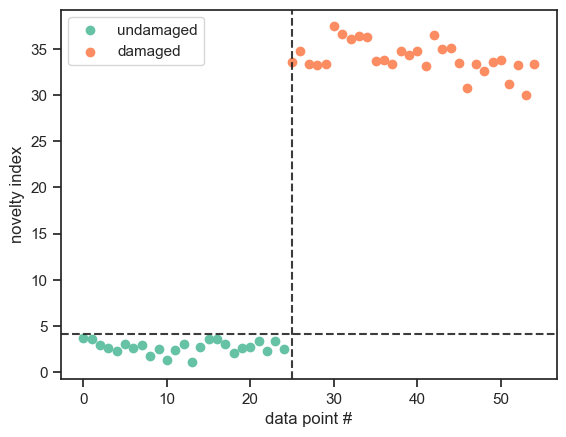

In [ ]:
# train novelty detector on range of undamaged, test on most severe damage.  

# construct reference/training values as every other undamaged case

reference_data = spectral_bands_undamaged[1::2,:]
damaged_data = spectral_bands_damaged[60:,:]

reference_data_amp = test_amplitude_undamaged[1::2]
damaged_data_amp = test_amplitude_damaged[60::]

damaged_data_severity = test_damage_severity[60::]

# calculate statistics of this data set

mu = np.mean(reference_data,0)
cov = np.cov(reference_data.T)
cov_inv = np.linalg.inv(cov)

# calculate their novelty index

reference_novelty = np.zeros_like((reference_data[:,0]))
damaged_novelty = np.zeros_like((damaged_data[:,0]))

for i in range(0,len(reference_data)):
    reference_novelty[i] = mahalanobis(reference_data[i,:],mu,cov_inv)
for i in range(0,len(damaged_data)):
    damaged_novelty[i] = mahalanobis(damaged_data[i,:],mu,cov_inv)

n = int(reference_data.shape[0])
p = int(reference_data.shape[1])
threshold = outlier_threshold(95,n,p)

x = np.arange(0,len(reference_novelty)+len(damaged_novelty))
y = np.hstack((reference_novelty,damaged_novelty))

plt.figure()
plt.scatter(
    x[0:len(reference_novelty)],y[0:len(reference_novelty)],marker = 'o',label ='undamaged'
    )
plt.scatter(
    x[len(reference_novelty):],y[len(reference_novelty):],marker = 'o',label = 'damaged'
    )
plt.axhline(y = threshold,linestyle ='--',color = 'k',alpha =0.85)
plt.axvline(x = len(reference_novelty),linestyle ='--',color = 'k',alpha =0.85)
plt.xlabel('data point #')
plt.ylabel('novelty index')
plt.legend(loc = 'upper left')

On the plot, the horizontal line represents the novelty threshold (e.g above the line is an outlier), and the vertical line represents the end of the reference/training data. 

We can see that the novelty detector is easilly able to distinguish being data originating from the undamaged and damaged condition. However, given that we're training entirely on undamaged data, and using data from the most severe damage, this isn't perhaps too suprising. 

Let's try a slightly more challenging scenario... use the same data as above to form the reference data, whilst using a range of tests from the undamaged and damage states. 

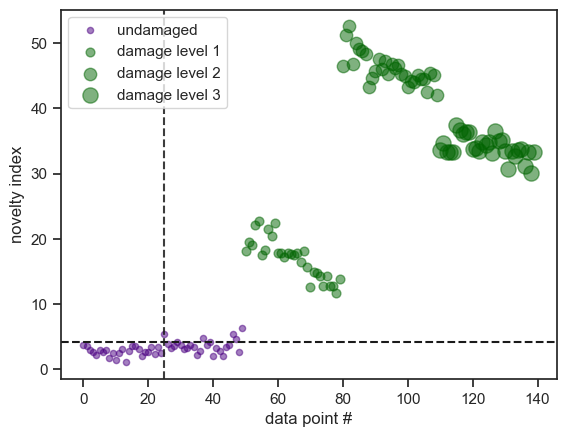

In [ ]:
# %% train novelty detector on range of undamaged, test on range of undamage and damage data. 

# construct reference values as every other undamaged case

reference_data = spectral_bands_undamaged[1::2,:]
undamaged_data = spectral_bands_undamaged[0::2,:]
damaged_data = spectral_bands_damaged

reference_data_amp = test_amplitude_undamaged[1::2]
undamaged_data_amp = test_amplitude_undamaged[0::2]
damaged_data_amp = test_amplitude_damaged

damaged_data_severity = test_damage_severity

# calculate statistics of this data set

mu = np.mean(reference_data,0)
cov = np.cov(reference_data.T)
cov_inv = np.linalg.inv(cov)

# calculate their novelty index

reference_novelty = np.zeros_like((reference_data[:,0]))
undamaged_novelty = np.zeros((spectral_bands_undamaged.shape[0]-reference_data.shape[0]))
damaged_novelty = np.zeros_like((spectral_bands_damaged[:,0]))

for i in range(0,len(reference_data)):
    reference_novelty[i] = mahalanobis(reference_data[i,:],mu,cov_inv)
for i in range(0,len(undamaged_data)):
    undamaged_novelty[i] = mahalanobis(undamaged_data[i,:],mu,cov_inv)
for i in range(0,len(damaged_data)):
    damaged_novelty[i] = mahalanobis(damaged_data[i,:],mu,cov_inv)

n = int(reference_data.shape[0])
p = int(reference_data.shape[1])
threshold = outlier_threshold(95,n,p)

# %% plot 

plot_outlier_analysis(threshold,
                      reference_novelty,
                      undamaged_novelty,
                      damaged_novelty,
                      damaged_data_severity)

We can see now that the results are not so clear cut, with a number of false positives (undamage instances classed as novel) now emerging. Have a think about what you think is making some of the undamage data points more novel than others. Rather encouragingly, however, is that all of the damage data are classed as novel.  

As a final example, let's load in another test series, DS_RLE, which corresponds to added mass at the root of the hawk wing. As the additional mass is now much closer to the fixed point of the wing that at the tip, it may prove harder to identify shifts in the FRF.

In [ ]:
# load in all DS_RLE tests

all_data = [("DS_RLE", np.arange(10,19))]

opts = {
    'data':'Frequency Response Function',
    'meta':True,
    'attrs':False,
    'compress_x_axis':True,
}

damage_RLE = {}
# loop through series
for series, runs in all_data:
    # loop through runs
    for run in runs:
        run_data = get_hawk_data('LMS', series, run, download_dir =data_dir, load_kwargs=opts, ask=0, quiet=1)
        # loop through reps
        for rep, rep_data in run_data.items():
            # loop through sensors
            for sensor, sensor_data in rep_data.items():
                if sensor != 'ULC-03': continue # 1 sensor only
                if sensor[:3] in {"TRI", "EXH", "FRC", "Met"}:
                    continue
                if int(sensor[-1])<3:
                    continue
                frf = sensor_data["Frequency Response Function"]["Y_data"]["value"]
                amp = run_data[rep]['Meta']['excitation']['LMSOutput']['value']
                if 'DS' in rep:
                    dmg = run_data[rep]['Meta']['additionalMass']['weight']['value']
                    damage_RLE[rep] = [frf,amp,dmg]

Let's take a look at the FRF for one of the DS_RLE tests, and the BR_AR (no damage) test that we looked at earlier.

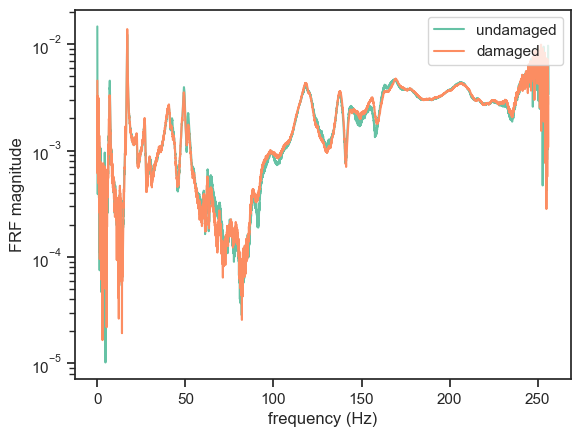

In [ ]:
plt.figure()
plt.plot(freqs,np.abs(out['BR_AR_5_1'][0]),label = 'undamaged')
plt.plot(freqs,np.abs(damage_RLE['DS_RLE_15_1'][0]), label = 'damaged')
plt.yscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('FRF magnitude')
plt.legend(loc = 'upper right')

ALthough the damage in RLE causes some change in the FRF, it is not as prominent of a change as the earlier damage location (TLE).

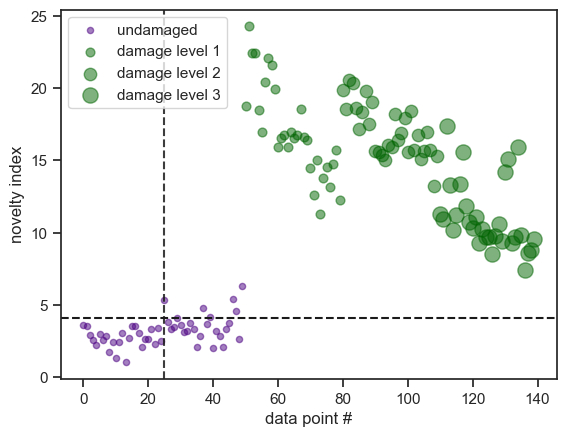

In [ ]:
spectral_bands_damaged_RLE = []
test_amplitude_damaged_RLE = []
test_damage_severity_RLE = []

for k, v in damage_RLE.items():
    spectral_bands_damaged_RLE.append(v[0][start_idx:end_idx:interval])
    test_amplitude_damaged_RLE.append(v[1]) 
    test_damage_severity_RLE.append(v[2])
    
spectral_bands_damaged_RLE = np.abs(spectral_bands_damaged_RLE)  
test_amplitude_damaged_RLE = np.array(test_amplitude_damaged_RLE)
test_damage_severity_RLE = np.array(test_damage_severity_RLE)

# retain reference statistics from earlier

damaged_novelty_RLE = np.zeros_like((spectral_bands_damaged_RLE[:,0]))

for i in range(0,len(spectral_bands_damaged_RLE)):
    damaged_novelty_RLE[i] = mahalanobis(spectral_bands_damaged_RLE[i,:],mu,cov_inv)

n = int(reference_data.shape[0])
p = int(reference_data.shape[1])
threshold = outlier_threshold(95,n,p)

# plot novelty

plot_outlier_analysis(threshold,
                      reference_novelty,
                      undamaged_novelty,
                      damaged_novelty_RLE,
                      test_damage_severity_RLE)


Although the outlier detection has done reasonably well at indicating the presence of damage, what we've considered here is just the tip of the iceberg! We've looked at the case where we have access to data that we believe to be from an undamaged state, and have then compared to simulated damage via the addition of mass. However, often we might not have prior access to data representative of undamaged conditions. In this scenario, maybe we'd like to adopt an online semi-supervised strategy, where we add labels to our data via inspections at times the algorithm determines there to be novelty. 

Another issue is that of confounding influences in the form of enviornmental and operational variation. Changes in temperature, wind loading conditions, traffic on a bridge (and so much more!) will all also cause changes in our data. However, as not representative of damage, we want to avoid our SHM algorithm flagging up these events as damage. 

Finally, we've only looked at the first stage of SHM; detection. As we move further up the SHM hiearachy, we encounter more involved tasks such as localisation, classification of damage type, and remaining useful life estimation. Whilst we get more insight into the damage on our structure by answering these questions, the challenge posed becomes much harder than detection alone. 